# Исследование надежности заемщиков. <a id="index"></a>

Заказчик — кредитный отдел банка.

Входные данные — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении подели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Цель исследования** — выявить влияние семейного положения и количество детей на факт погашения кредита в срок.

**Ход исследования**

Информация о клиентах находится в файле `/datasets/data.csv`. Данные представлены в "сыром" виде, необходима предобработка.

Поставленные вопросы:
* 1. Есть ли зависимость между количеством детей и возвратом кредита в срок?
* 2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
* 3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* 4. Как разные цели кредита влияют на его возврат в срок?

### Шаг 1. Обзор данных

In [1]:
# импорт необходимых библиотек
import pandas as pd

In [2]:
# получаем данные, изучаем общую информацию
df = pd.read_csv('/datasets/data.csv')
df.info()
print('-' * 70)
display(df.head(10))

#проверяем наличие дубликатов
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
----------------------------------------------------------------------


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


54

На небольшом отрезке таблицы в столбцах `education` и `purpose` очевидны неявные дубликаты и некорректные данные. Проверяем остальные столбцы: <a id="value_counts"></a>

In [3]:
columns_without_problems = ['income_type', 'children', 'dob_years', 'family_status', 'family_status_id', 'gender', 'debt']
for column in columns_without_problems:
    print(df[column].value_counts()) #используем .value_counts(), а не .unique() с целью понимания являются ли ошибки системными или единичными выбросами
    print('-' * 70)
    
total_income_df = df.sort_values(by='total_income').dropna() #отрицательные и неадекватные значения в списке дохода ищем другим путём
print(total_income_df['total_income'].astype(int))

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64
----------------------------------------------------------------------
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
----------------------------------------------------------------------
35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69 

В результате первичного изучения данных выявлен ряд проблем, препятствующий качественному анализу: <a id="anomaly"></a>
* Неоднозначные названия столбцов;
* Пропущенные значения в столбцах `days_employed`, `total_income`;
* Некорректные значения в столбце `days_employed`;
* Неоднородные значения в столбце `education` (неявные дубликаты);
* Неоднородные значения в столбце `purpose`;
* Некорректные данные в столбце `total_income` (миллионные доли, неизвестные единицы измерения);</a>
* Отрицательные и превышенные значения в столбце `children`;
* Нулевые значения в столбце `dob_years`.

Для дальнейшей работы необходимо привести названия столбцов к однозначным наименованиям. <a id="p1"></a>

In [4]:
df = df.rename(columns={
    'children': 'children_count', #иначе можно понять значение как "да/нет" - "1/0"
    'dob_years': 'age', #не сразу понятно что такое dob, да и даты рождения в столбце нет 
    'total_income': 'income_per_month'#на основании диапазона значений можем предполагать, что указана месячная зарплата
})

#проверяем изменения
print(df.columns)

Index(['children_count', 'days_employed', 'age', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'income_per_month', 'purpose'],
      dtype='object')


### Шаг 2.1 Заполнение пропусков

Вычисляем долю строк с пропущенными значениями: <a id="p2"></a>

In [5]:
count_nulls = df['days_employed'].isna().sum()
count_len = len(df['days_employed'])
print(f'Количество пропущенных значений: {count_nulls} из {count_len}, что соответствует {int(count_nulls / count_len * 100)}%')

Количество пропущенных значений: 2174 из 21525, что соответствует 10%


10% является весомым количеством для анализа данных, поэтому для задачи №3 создадим новый датафрейм, отфильтрованный от строк с пустыми значениями:

In [6]:
#удаляем пропуски и сбрасываем индексы
df_cleared = df.dropna().reset_index(drop=True)

#проверяем результаты, должна быть 19351 строка
print(len(df_cleared))

#чтобы избежать дальнейшей нецелесообразной обработки данных удаляем все столбцы из нового датафрейма, кроме нужных
#столбец `days_employed` и `income_type` оставляем для анализа аномалий в значениях
df_cleared = df_cleared.drop(['children_count', 'age', 'education', 'education_id', 'family_status', 'family_status_id', 'gender', 'purpose'], axis=1)
display(df_cleared)

19351


,days_employed,income_type,debt,income_per_month
0,-8437.673028,сотрудник,0,253875.639453
1,-4024.803754,сотрудник,0,112080.014102
2,-5623.422610,сотрудник,0,145885.952297
3,-4124.747207,сотрудник,0,267628.550329
4,340266.072047,пенсионер,0,158616.077870
...,...,...,...,...
19346,-4529.316663,компаньон,0,224791.862382
19347,343937.404131,пенсионер,0,155999.806512
19348,-2113.346888,сотрудник,1,89672.561153
19349,-3112.481705,сотрудник,1,244093.050500


Для задач №1, №2, №4 данные из столбцов `days_employed` и `income_per_month` не имеют значения, поэтому заполняем пропущенные значения медианными:

In [7]:
#вычисляем медианы для days_employed и total_income
days_employed_median = df['days_employed'].dropna().median()
total_income_median = df['income_per_month'].dropna().median()

#заполняем пропуски медианными значениями
df['days_employed'] = df['days_employed'].fillna(days_employed_median)
df['income_per_month'] = df['income_per_month'].fillna(total_income_median)

#проверяем заполнение, количество медианных значение должно быть равно 2174 или 2175, в зависимости от чётности/нечётности размера массива
print(df['days_employed'].value_counts())
print(df['income_per_month'].value_counts())

display(df[df['income_per_month'] == total_income_median])

-1203.369529      2175
-327.685916          1
-4399.664923         1
-4122.460569         1
-2828.237691         1
                  ... 
-2146.884040         1
-881.454684          1
-794.666350          1
 372337.985304       1
-3382.113891         1
Name: days_employed, Length: 19351, dtype: int64
145017.937533    2175
106196.235958       1
45654.214129        1
132775.748481       1
127240.919486       1
                 ... 
239154.168013       1
165009.733021       1
94270.049769        1
68166.012050        1
189255.286637       1
Name: income_per_month, Length: 19351, dtype: int64


,children_count,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,income_per_month,purpose
12,0,-1203.369529,65,среднее,1,гражданский брак,1,M,пенсионер,0,145017.937533,сыграть свадьбу
26,0,-1203.369529,41,среднее,1,женат / замужем,0,M,госслужащий,0,145017.937533,образование
29,0,-1203.369529,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,145017.937533,строительство жилой недвижимости
41,0,-1203.369529,50,среднее,1,женат / замужем,0,F,госслужащий,0,145017.937533,сделка с подержанным автомобилем
55,0,-1203.369529,54,среднее,1,гражданский брак,1,F,пенсионер,1,145017.937533,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,-1203.369529,47,Среднее,1,женат / замужем,0,M,компаньон,0,145017.937533,сделка с автомобилем
21495,1,-1203.369529,50,среднее,1,гражданский брак,1,F,сотрудник,0,145017.937533,свадьба
21497,0,-1203.369529,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,145017.937533,строительство недвижимости
21502,1,-1203.369529,42,среднее,1,женат / замужем,0,F,сотрудник,0,145017.937533,строительство жилой недвижимости


Промежуточный итог:
В основном датафрейме пустые значения заполнены медианными значениями, сохранён в переменной `df`.

Датафрейм для задачи №2 без строк с пустыми значениями сохранён в переменной `df_cleared`.

### Шаг 2.2 Проверка данных на аномалии и исправления.

На шаге обзора данных были выявлены <a href="#anomaly">аномалии</a> в данных.

#### Шаг 2.2.1 Аномалии в столбце `days_employed` <a id="p3"></a>

Данные в столбце распределены от отрицательных значений до неадекватно больших. Распределение данных ненаглядно, построим гистограмму для понимания распределения.

AxesSubplot(0.125,0.125;0.775x0.755)


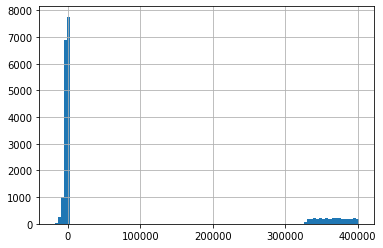

In [8]:
print(pd.Series(df_cleared['days_employed']).hist(bins=100))

Значения распределены неравномерно, имеется два участка:

1. от отрицательных до 0;
2. примерно от 320000 до 400000.

Рассмотрим участки подробнее по-отдельности:

AxesSubplot(0.125,0.125;0.775x0.755)


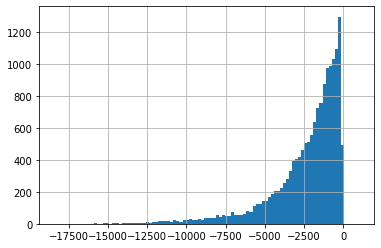

In [9]:
#строим гистограмму от минимального до 0
#верхний предел пока не устанавливаем на нуле, так как мы не можем достоверно утверждать, что положительные околонулевые значения отсутствуют 
#работаем с очищенным датафреймом df_cleared, так как заполненные медианой строки дадут существенный выброс
print(pd.Series(df_cleared['days_employed']).hist(bins=100, range=(df_cleared['days_employed'].min(), 1000)))

Данные похожи на корректные: при стаже около 0 клиенты не подают заявки на кредиты, так как в банках часто установлено ограничение по минимальному стажу на последнем рабочем месте. Распределение также выглядит правдоподобным - при смене места работы количество людей со стажем уменьшается, наполняя околонулевые значения.

AxesSubplot(0.125,0.125;0.775x0.755)


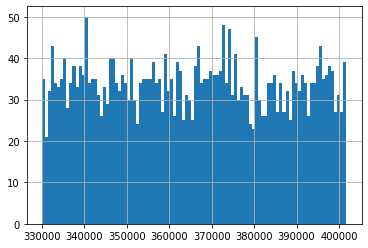

In [10]:
#строим гистограмму для второго диапазона значений
print(pd.Series(df_cleared['days_employed']).hist(bins=100, range=(330000, df_cleared['days_employed'].max())))

Распределение выглядит случайным, отсутствуют тренд и явные пики. Диапазон захватывает промежуток времени в 191,7 лет, из чего также нельзя сделать определённые выводы. Предполагаем, что эти значения проявляются в строках, где стаж работы неприменим. Изучив <a href="#value_counts">топ-4</a> значений по частоте в столбце `income_type` обнаруживаем, что для проверки предположения нам подходят пенсионеры.

Проверяем гипотезу:

In [11]:
#используем последовательную фильтрацию. 1. Выделяем стаж всех пенсионеров:
pensioner_employed = df_cleared[df_cleared['income_type'] == 'пенсионер']['days_employed']
#2. Выделяем пенсионеров со стажем меньше 320000
pensioner_employed = pensioner_employed[pensioner_employed < 320000]
#выводим на экран, ожидаем увидеть пустой датафрейм
print(pensioner_employed)


Series([], Name: days_employed, dtype: float64)


Предположение подтвердилось: все пенсионеры учтены в диапазоне от 330000 и выше.

Тем не менее, нельзя утверждать, что все учтённые в диапазоне от 330000 и выше - пенсионеры. 

Допускаем увидеть в полученной выборке студентов, безработных и предпринимателей, но мы не ожидаем обнаружить в выборке сотрудников, компаньонов и госслужащих.

In [12]:
immortal_workers_count = df_cleared[df_cleared['days_employed'] > 320000]
print(immortal_workers_count['income_type'].value_counts())

пенсионер      3443
безработный       2
Name: income_type, dtype: int64


Рассмотрим значения `days_employed`, а заодно и другие данные, для безработных:

In [13]:
display(immortal_workers_count[immortal_workers_count['income_type'] == 'безработный'])

,days_employed,income_type,debt,income_per_month
2832,337524.466835,безработный,1,59956.991984
13347,395302.838654,безработный,0,202722.511368


Из полученных данных можем предположить, что оба безработных занимаются сдачей или перепродажей жилья, но не оформлены как предприниматели.
К сожалению, причина больших положительных значений пока не определена. Для выполнения поставленных задач не требуется понимание стажа работы, поэтому оставляем данные в существующем виде для дальнейших выяснений. Ошибочные значения не удаляем, так как данные будут утеряны после понимания дефекта.

Строки с отрицательными значениями переведём в года и изменим знак на противоположный:

In [14]:
#так как при делении значения int переводятся в float, проводим операции последовательно
df['years_employed'] = df['days_employed'].abs() / 365
df['years_employed'] = df['years_employed'].astype(int)
df_cleared['years_employed'] = df_cleared['days_employed'].abs() / 365

#### Шаг 2.2.1 Аномалии в столбце `children` (переименовано на `children_count`)

В столбце встречаются два аномальных значения: "20" и "-1". Для задачи №1 важно точно понимать количество детей, поэтому некорректные строки удаляем из датафрейма:

In [15]:
#записывам новый датафрейм в переменную, которую будем использовать только для задачи №1
df_task_1 = df.query('children_count not in [20, -1]')
#чтобы не проводить предобработку всех значений в датафрейме, которые не нужны для решения задачи, оставим только необходимые столбцы
df_task_1 = df_task_1.drop(['years_employed', 'days_employed', 'age', 'education', 'education_id', 'family_status', 'family_status_id', 'gender', 'income_type', 'income_per_month', 'purpose'], axis=1)

#проверяем выполнение операции
print(df_task_1['children_count'].value_counts())

#для остальных датафреймов заполняем некорректные значения медианой
children_median = df_task_1['children_count'].median().astype(int)
df['children_count'] = df['children_count'].replace(to_replace=[20, -1], value=children_median)

0    14149
1     4818
2     2055
3      330
4       41
5        9
Name: children_count, dtype: int64


#### Шаг 2.2.2 Неоднородные записи в столбце `education` <a id="p4"></a>

В столбце `education` обнаружены записи в разных регистрах. Приведём все значения к нижнему регистру:

In [16]:
df['education'] = df['education'].str.lower()

#Проверяем значения
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

#### Неоднородные значения в столбце `purpose`

В столбце `purpose` имеются неявные дубликаты. Приведём одинаковые по смыслу значения к уникальным.

In [17]:
#Рассмотрим уникальные значения
unique_purposes = df['purpose'].sort_values()
print(unique_purposes.unique())

['автомобили' 'автомобиль' 'высшее образование'
 'дополнительное образование' 'жилье' 'заняться высшим образованием'
 'заняться образованием' 'на покупку автомобиля'
 'на покупку подержанного автомобиля' 'на покупку своего автомобиля'
 'на проведение свадьбы' 'недвижимость' 'образование' 'операции с жильем'
 'операции с коммерческой недвижимостью' 'операции с недвижимостью'
 'операции со своей недвижимостью' 'покупка жилой недвижимости'
 'покупка жилья' 'покупка жилья для сдачи' 'покупка жилья для семьи'
 'покупка коммерческой недвижимости' 'покупка недвижимости'
 'покупка своего жилья' 'получение высшего образования'
 'получение дополнительного образования' 'получение образования'
 'приобретение автомобиля' 'профильное образование' 'ремонт жилью'
 'свадьба' 'свой автомобиль' 'сделка с автомобилем'
 'сделка с подержанным автомобилем' 'строительство жилой недвижимости'
 'строительство недвижимости' 'строительство собственной недвижимости'
 'сыграть свадьбу']


In [18]:
#Функция для замены неявных дубликатов
def replace_wrong_purposes(wrong_purposes, correct_purpose):
    for wrong_purpose in wrong_purposes:
        df['purpose'] = df['purpose'].replace(wrong_purpose, correct_purpose)
        
#Устраняем дубликаты
wrong_duplicates = ['автомобили', 'автомобиль', 'на покупку автомобиля', 'на покупку подержанного автомобиля', 'на покупку своего автомобиля', 'приобретение автомобиля', 'свой автомобиль', 'сделка с автомобилем', 'сделка с подержанным автомобилем']
correct_unique = 'покупка автомобиля'
replace_wrong_purposes(wrong_duplicates, correct_unique)

wrong_duplicates = ['высшее образование', 'дополнительное образование', 'заняться высшим образованием', 'заняться образованием', 'образование', 'получение высшего образования', 'получение дополнительного образования', 'получение образования', 'профильное образование'] 
correct_unique = 'образование'
replace_wrong_purposes(wrong_duplicates, correct_unique)

wrong_duplicates = ['покупка своего жилья', 'жилье', 'недвижимость', 'операции с жильем', 'операции с коммерческой недвижимостью', 'операции со своей недвижимостью', 'операции с недвижимостью', 'покупка жилой недвижимости', 'покупка жилья', 'покупка жилья для сдачи', 'покупка жилья для семьи', 'покупка коммерческой недвижимости', 'покупка недвижимости' 'покупка своего жилья', 'строительство жилой недвижимости', 'строительство недвижимости', 'строительство собственной недвижимости'] 
correct_unique = 'покупка недвижимости'
replace_wrong_purposes(wrong_duplicates, correct_unique)

wrong_duplicates = ['на проведение свадьбы', 'сыграть свадьбу'] 
correct_unique = 'свадьба'
df = df.replace('ремонт жилью', 'ремонт')

replace_wrong_purposes(wrong_duplicates, correct_unique)
print(df['purpose'].sort_values().unique())

['образование' 'покупка автомобиля' 'покупка недвижимости' 'ремонт'
 'свадьба']


#### Вывод:
1. Необходимо разобраться в принципе заполнения `days_employed` для пенсионеров и безработных: являются ли данные ошибочными или представлены в неправильном виде;
2. От основного датафрейма ответвлён `df_task_1`


### Шаг 2.3. Изменение типов данных.

Некорректный тип данных встречается в столбцах:
* `days_employed`, `income_per_month` - перевести float в int;
* `debt` - перевести в bool

In [19]:
df['days_employed'] = df['days_employed'].abs().astype(int)
df_cleared['days_employed'] = df_cleared['days_employed'].abs().astype(int)

df['income_per_month'] = df['income_per_month'].astype(int)
df_cleared['income_per_month'] = df_cleared['income_per_month'].astype(int)

df['debt'] = df['debt'].astype(bool)
df_cleared['debt'] = df_cleared['debt'].astype(bool)

#Проверяем изменения
df_cleared.dtypes

days_employed         int64
income_type          object
debt                   bool
income_per_month      int64
years_employed      float64
dtype: object

### Шаг 2.4. Удаление дубликатов.

In [20]:
#проверяем наличие дубликатов
df.duplicated().sum()

386

Дубликаты можно допустить, так как отсутствуют уникальные id каждого клиента, а пересечения возможны, т.к. количество комбинаций не такое большое, как может показаться: определённые группы людей имеют определённый возраст, с высокой вероятностью будут иметь похожий уровень заработка, стаж работы и схожую цель кредита.

На этапе первичного просмотра датафрейма количество дубликатов было 54. После очистки данных - 378, что может указывать на уникальность всех данных, а все дубликаты - совпадения.


In [21]:
#Проверим наличие дубликатов в отфильтрованном датафрейме
df_cleared.duplicated().sum()

0

Из этого следует, что дубликаты образуются в строках, где пропущены значения в столбцах `days_employed` и `income_per_month`, что дополнительно подтверждает вероятность уникальности всех значений, то есть все дубликаты - это разные клиенты, но с одинаковыми данными.

На основании полученых данных можно утверждать, что миллионные доли в столбцах `days_employed` и `income_per_month` можно принимать за "подпись", подтверждающую уникальность данных.

Принимаем решение не удалять дубликаты.

Для дальнейшего анализа в очищенном датафрейме можем оставить только необходимые столбцы:

In [22]:
df_cleared = df_cleared.drop(['days_employed', 'income_type', 'years_employed'], axis=1)
display(df_cleared)

,debt,income_per_month
0,False,253875
1,False,112080
2,False,145885
3,False,267628
4,False,158616
...,...,...
19346,False,224791
19347,False,155999
19348,True,89672
19349,True,244093


### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

В основном датарейме существуют столбцы со значениями и соответствующими id. Создадим датафреймы словари:

#### Шаг 2.5.1. Словарь для `education`

In [23]:
#Вводим новую переменную со словарём
education_dict = df[['education', 'education_id']]

#Удаляем дубликаты
education_dict = education_dict.drop_duplicates().reset_index(drop=True)

display(education_dict)

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


#### Шаг 2.5.2. Словарь для `family_status`

In [24]:
family_status_dict = df[['family_status', 'family_status_id']]

family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)

display(family_status_dict)

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


Для простоты чтения таблицы удаляем столбцы с дублирующейся информацией

In [25]:
df = df.drop(['education', 'family_status'], axis=1)
display(df)

,children_count,days_employed,age,education_id,family_status_id,gender,income_type,debt,income_per_month,purpose,years_employed
0,1,8437,42,0,0,F,сотрудник,False,253875,покупка недвижимости,23
1,1,4024,36,1,0,F,сотрудник,False,112080,покупка автомобиля,11
2,0,5623,33,1,0,M,сотрудник,False,145885,покупка недвижимости,15
3,3,4124,32,1,0,M,сотрудник,False,267628,образование,11
4,0,340266,53,1,1,F,пенсионер,False,158616,свадьба,932
...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,1,1,F,компаньон,False,224791,покупка недвижимости,12
21521,0,343937,67,1,0,F,пенсионер,False,155999,покупка автомобиля,942
21522,1,2113,38,1,1,M,сотрудник,True,89672,покупка недвижимости,5
21523,3,3112,38,1,0,M,сотрудник,True,244093,покупка автомобиля,8


**Вывод:** созданы датафреймы словари с id семейного положения и id уровня образования.

### Шаг 2.6. Категоризация дохода.

Для упрощения дальнейшего анализа необходимо перевести данные о доходе клиентов в более наглядный вид. Категоризируем значения:

In [26]:
#Назначаем функцию с правилом категоризации
def income_group(income_per_month):
    try:       #мы проверили, но вдруг где-то есть отрицательное значение или не число
        if 0 < income_per_month <= 30000:
            return 'E'
        elif income_per_month <= 50000:
            return 'D'
        elif income_per_month <= 200000:
            return 'C'
        elif income_per_month <= 1000000:
            return 'B'
        elif income_per_month > 1000000:
            return 'A'
    except:
        return ''
    
#Добавляем столбец с категорией в основной датафрейм
df['total_income_category'] = df['income_per_month'].apply(income_group)
df_cleared['total_income_category'] = df_cleared['income_per_month'].apply(income_group)
display(df)

,children_count,days_employed,age,education_id,family_status_id,gender,income_type,debt,income_per_month,purpose,years_employed,total_income_category
0,1,8437,42,0,0,F,сотрудник,False,253875,покупка недвижимости,23,B
1,1,4024,36,1,0,F,сотрудник,False,112080,покупка автомобиля,11,C
2,0,5623,33,1,0,M,сотрудник,False,145885,покупка недвижимости,15,C
3,3,4124,32,1,0,M,сотрудник,False,267628,образование,11,B
4,0,340266,53,1,1,F,пенсионер,False,158616,свадьба,932,C
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,1,1,F,компаньон,False,224791,покупка недвижимости,12,B
21521,0,343937,67,1,0,F,пенсионер,False,155999,покупка автомобиля,942,C
21522,1,2113,38,1,1,M,сотрудник,True,89672,покупка недвижимости,5,C
21523,3,3112,38,1,0,M,сотрудник,True,244093,покупка автомобиля,8,B


**Вывод:** присвоены категории клиентам в зависимости от уровня дохода.

### Шаг 2.7. Категоризация целей кредита.

Цели кредита были объединены как неявные дубликаты. При дальнейшем наполнении датайрейма введём автоматическую категоризацию целей.

In [27]:
def purpose_group(purpose):
    try:
        if 'авто' in purpose:
            return 'операции с автомобилем'
        elif 'недвиж' in purpose:
            return 'операции с недвижимостью'
        elif 'жил' in purpose:
            return 'операции с недвижимостью'
        elif 'ремонт' in purpose:
            return 'операции с недвижимостью'
        elif 'свад' in purpose:
            return 'проведение свадьбы'
        elif 'жени' in purpose:
            return 'проведение свадьбы'
        elif 'образ' in purpose:
            return 'получение образования'        
    except:
        return 'другое'
    

df['purpose_category'] = df['purpose'].apply(purpose_group)
display(df)

,children_count,days_employed,age,education_id,family_status_id,gender,income_type,debt,income_per_month,purpose,years_employed,total_income_category,purpose_category
0,1,8437,42,0,0,F,сотрудник,False,253875,покупка недвижимости,23,B,операции с недвижимостью
1,1,4024,36,1,0,F,сотрудник,False,112080,покупка автомобиля,11,C,операции с автомобилем
2,0,5623,33,1,0,M,сотрудник,False,145885,покупка недвижимости,15,C,операции с недвижимостью
3,3,4124,32,1,0,M,сотрудник,False,267628,образование,11,B,получение образования
4,0,340266,53,1,1,F,пенсионер,False,158616,свадьба,932,C,проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,1,1,F,компаньон,False,224791,покупка недвижимости,12,B,операции с недвижимостью
21521,0,343937,67,1,0,F,пенсионер,False,155999,покупка автомобиля,942,C,операции с автомобилем
21522,1,2113,38,1,1,M,сотрудник,True,89672,покупка недвижимости,5,C,операции с недвижимостью
21523,3,3112,38,1,0,M,сотрудник,True,244093,покупка автомобиля,8,B,операции с автомобилем


### Ответы на вопросы.

##### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

Построим сводную таблицу на основании датафрейма `df_task_1` с очищенными от некорректных значений в столбце `children_count` данными.
Для этого посчитаем количество клиентов, которые вернули кредит в срок, количество клиентов, которые не вернули кредит в срок, и вычислим процент должников.

In [28]:
children_debt = df_task_1.groupby('children_count')['debt'].count()
children_grouped = df_task_1.groupby('children_count')['debt'].sum()
children_debt_merged = (pd
                        .concat([children_debt, children_grouped], axis=1)
                        .set_axis(['sum', 'debt'], axis=1, inplace=False)
                       )
children_debt_merged['percentage'] = children_debt_merged['debt'] / children_debt_merged['sum'] * 100
display(children_debt_merged)

# Далее применены более лаконичные решения для задач подобного принципа

,sum,debt,percentage
children_count,,,
0,14149,1063,7.512898
1,4818,444,9.215442
2,2055,194,9.440389
3,330,27,8.181818
4,41,4,9.756098
5,9,0,0.000000


In [29]:
df_task_1.groupby('children_count').agg(число_клиентов=('debt','count'), число_должников=('debt','sum'), доля_должников=('debt','mean'))\
    .style.format({'доля_должников' : '{:.2%}'.format})

,число_клиентов,число_должников,доля_должников
children_count,,,
0,14149,1063,7.51%
1,4818,444,9.22%
2,2055,194,9.44%
3,330,27,8.18%
4,41,4,9.76%
5,9,0,0.00%


###### Вывод 1:

Очевидноая зависимость между количеством детей и задолженностью по кредиту отсутсвует. 
Клиенты без детей имеют меньше задолженностей по кредитам.
Для клиентов с 4 и более детьми количества данных недостаточно для однозначного вывода.

##### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [30]:
family_status_ind = df.pivot_table(index=['family_status_id'], columns=['debt'], values='purpose', aggfunc='count')
family_status_ind['percentage'] = family_status_ind[1] / family_status_ind[0] * 100
family_status_ind['status'] = family_status_dict['family_status'] #Вернём из словаря расшифровку
family_status_ind

debt,False,True,percentage,status
family_status_id,,,,
0,11449,931,8.131715,женат / замужем
1,3789,388,10.240169,гражданский брак
2,897,63,7.023411,вдовец / вдова
3,1110,85,7.657658,в разводе
4,2539,274,10.791650,Не женат / не замужем


###### Вывод 2:

Существенных отклонений от среднего процента задолженностей между различными группами не наблюдается.

Неженатые/незамужние клиенты чаще имели задолженности по кредитам. Незначительно проявляется зависимость отсутствия задолженности от предполагаемого возраста клиента: незамужние/неженатые клиенты и люди в гражданском браке чаще моложе и имеют менее стабильные жизненные ситуации, чем вдовцы/вдовы и клиенты в разводе, которые, обычно, старше.

##### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [31]:
#Для ответа на поставленный вопрос необходимо использовать очищенный от медиан и пропущенных значений датафрейм
income_ind = df_cleared.pivot_table(index=['total_income_category'], columns=['debt'], values='income_per_month', aggfunc='count')
income_ind['percentage'] = income_ind[1] / income_ind[0] * 100
income_ind

debt,False,True,percentage
total_income_category,,,
A,23,2,8.695652
B,4685,356,7.598719
C,12723,1190,9.353140
D,329,21,6.382979
E,20,2,10.000000


###### Вывод 3:

Полученные данные ненаглядны, отсутствует явная зависимость задолженностей от категории.

Для людей из категории E и A анализ неприменим по причине отсутствия адекватной выборки.

Также отсутствует информация по критериям выдачи кредитов клиентам из разных категорий. Возможно, алгоритм, принимающий решение о выдаче кредита, корректнее работает, анализируя клиентов из категории D и B, а людям из категории C чаще ошибочно одобрялись кредиты. Например, люди из категории C могли предоставлять банку данные с завышенным доходом.

##### Вопрос 4: Как разные цели кредита влияют на его возврат в срок?

In [32]:
purpose_ind = df.pivot_table(index='purpose_category', columns=['debt'], values='income_per_month', aggfunc='count')
purpose_ind['percentage'] = purpose_ind[1] / purpose_ind[0] * 100
purpose_ind

debt,False,True,percentage
purpose_category,,,
операции с автомобилем,3912,403,10.301636
операции с недвижимостью,10058,782,7.774906
получение образования,3652,370,10.131435
проведение свадьбы,2162,186,8.603145


###### Вывод 4:

Клиенты имеют больше задолженностей по автокредитам и кредитам на образование.

Кредиты на свадьбу и операции с недвижимостью возвращают в срок чаще.

## Общий вывод:

**Результаты предобработки данных:**
1. Необходимо стандартизировать варианты ответов при заполнении данных. Таким образом можно исключить:
    - неявные дубликаты в данных о целях получения кредита;
    - неявные дубликаты в данных об уровне образования;
    - отрицательные и завышенные значения в данных о количестве детей;
    - нулевое значение в данных о возрасте;
    - неверные данные в данных о поле.
2. Необходимо выявить и исправить источник некорректной записи данных в столбце со стажем работы:
    - причина появления отрицательных значений;
    - причина появления нецелых значений;
    - причина появления больших значений стажа у пенсионеров.
3. Необходимо уточнить причину появления миллионных долей в значениях дохода


**Результаты анализа данных:**

При анализе зависимости наличия задолженности от одного фактора не выявлены однозначные результаты. Предполагаем, что зависимость, чаще всего, многофакторная. Незначительные отклонения от среднего выявлены в следующих зависимостях:
1. Клиенты без детей имеют меньше задолженностей;
2. Вдовцы/вдовы и клиенты в разводе имеют меньше задолженностей, чем неженатые;
3. Люди с доходом от 50 до 200 тысяч чаще имеют задолженности;
    - необходимо обратить внимание на алгоритм одобрения кредитов для данной категории клиентов
4. Автокредиты и кредиты на образование возвращаются в срок реже, чем кредиты на операции с недвижимостью и кредиты на свадьбу.